In [5]:
%matplotlib inline
%load_ext Cython


import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import itertools

In [6]:
%cd ../
import CythonDTW
import TSM_Import

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
hop_length = 512

In [8]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [9]:
sr = 22050

In [10]:
def getChromaFeatures(audio):
    chroma = lb.feature.chroma_stft(audio, norm=2)
    return chroma
def getCostMatrix(query, ref):
    return sspat.distance.cdist(query.T, ref.T, metric='cosine')
def get_piece():
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece
def getAssignment(query_length=3):
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                for query_index in range(len(query_list)//query_length):
                    count+=1
    return assignment

In [12]:
def writeToFile( solo_id, orch_id, segment_id, error_ls, hypdir):
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}-{}.hyp".format(hypdir, solo_id, orch_id,segment_id)
        with open (fname, 'wb') as f:
            pkl.dump((error_ls),f)

In [15]:
def getITF(wp,itf_length):
    array = np.zeros(itf_length+1)
    wp = wp * 512
    
    slope = 1
    
    for pair_idx in range(1,len(wp)):
        x0, x1 = wp[pair_idx-1,0],wp[pair_idx,0]
        y0, y1 = wp[pair_idx-1,1],wp[pair_idx,1]
        slope = (y1-y0)/(x1-x0)
        array[x0:x1] = y0 + slope * np.arange(x1-x0)
        array[x1] = y1
    
    wp_end_x, wp_end_y = wp[-1][0], wp[-1][1]
    
    if len(array) > wp_end_x+1:
        array[wp_end_x+1:] = wp_end_y + np.arange(len(array) - wp_end_x -1)*slope + 1
    
    return array

In [20]:
class RegularDTW():
    def __init__(self, ref_audio):
        
        self.ref_chroma = getChromaFeatures(ref_audio)
        self.est_curr_frame = 0

    def newSeg(self, est_ref_start_time, est_ref_end_time):
        self.est_curr_frame = max(est_ref_start_time * sr / 512,0) 
        self.start_chroma_idx = max(est_ref_start_time * sr /512,0)
        self.end_chroma_idx = max(est_ref_end_time * sr/512,0)
        self.short_ref_chroma = self.ref_chroma[:,int(self.start_chroma_idx):int(self.end_chroma_idx)]
        
    def align(self,query_audio):
        
        
        #print("start",self.est_curr_frame, self.start_chroma_idx, self.est_curr_frame*512/sr, self.start_chroma_idx*512/sr)
        
        query_chroma = getChromaFeatures(query_audio)
        self.cost_matrix = getCostMatrix(query_chroma, self.short_ref_chroma)
        steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))  
        weights = [2,1,1]
        D, wp = lb.sequence.dtw(C=self.cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
        
        
        #wp = realTimeDTW(self.cost_matrix, steps, weights,int(self.est_curr_frame-self.start_chroma_idx))
        wp = np.sort(wp,axis=0)
        
        wp[:,1]+=int(self.start_chroma_idx)
        
        itf_length = len(query_audio)        
        
        #self.est_curr_frame = int(max(self.est_curr_frame, wp[-1,1]))
        
        itf = getITF(wp, itf_length)
        
        #print(itf.shape)
        
        return itf, wp 

In [24]:
def evalITF(piece_id,segment_id,orch_id,solo_id):
    
    query_len = .5
    
    diff_ls = []
    
    time_signature = [2,4,4,4]
    
    segment_info = queryInfo['p'+str(piece_id+1)+'s']
    segment = []
    for raw_seg in segment_info:
        start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
        segment.append([start,end])
    
    start, end = segment[segment_id]
    query_list = []
    query_index = start
    while query_index != end:            
        query_list.append(query_index)
        measure = int(query_index[:query_index.index('.')])
        beat = int(query_index[query_index.index('.')+1:])
        if beat == time_signature[piece_id]:
            beat = 1
            measure+=1
            query_index = str(measure)+"."+str(beat)
        else:
            beat+=1
            query_index = str(measure)+"."+str(beat)
            query_list.append(query_index)
    
    
    ref_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
    
    first_query = query_list[0]
    
    orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
    
    orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
    orch_end_time = orch_time_data[query_list[-1]]
    est_ref_start_time, est_ref_end_time = max(orch_start_time - 1,0),orch_end_time+1
    
    tDTW = RegularDTW(ref_audio)
    tDTW.newSeg(est_ref_start_time, est_ref_end_time)
    
    itf_ls = []
    
    for query_sec in range(0, len(solo_audio), int(query_len*sr) ):
        

        
        input_audio = solo_audio[int(query_sec):int(query_sec+query_len*sr)]
        
        if len(input_audio) < 1:
            print("input audio too short")
        
        #print(len(input_audio)/sr, orch_start_time)
        
        itf, wp = tDTW.align(input_audio)
        
        #return itf,wp
        
        itf_ls.extend(itf)
        
    itf_ls = np.array(itf_ls)
    
    #print(itf_ls.shape)
    
    duplicate_set = set()
    

    
    for idx, query in enumerate(query_list):
        solo_input_sec = solo_time_data[query] 
        orch_output_sec = orch_time_data[query]
        
        if math.isnan(solo_input_sec) or math.isnan(orch_output_sec):
            continue
        
        solo_input_sec -=  solo_start_time
        solo_input_idx = int(solo_input_sec * sr)
        
        ground_truth = orch_output_sec * sr
        
        if solo_input_sec in duplicate_set:
            continue
        else:
            duplicate_set.add(solo_input_sec)
    
        if solo_input_idx >= len(itf_ls):
            print("index too large")
            continue
        
        prediction = itf_ls[solo_input_idx]
        

        
        diff =  ground_truth - prediction 
        
        if (abs(diff/sr) > 1.2 and debug): 
            print( piece_id,segment_id,orch_id,solo_id, idx )
            print("    ",diff/sr,"    ", ground_truth/sr,prediction/sr)
        
        diff_ls.append(diff)
        
        #print(prediction/sr, ground_truth/sr, diff/sr,solo_input_sec)
    
    return diff_ls#, itf_ls
def evalAll(hypdir, restart=False):
    diff_ls = []
    assignment = getAssignment(1)
    for assignment_idx in range(len(assignment)):
        
        piece_id,segment_id,orch_id,solo_id = assignment[assignment_idx]
        print(assignment_idx,piece_id,segment_id,orch_id,solo_id)
        outfile = 'experiments/{}/{}-{}-{}.hyp'.format(hypdir, solo_id, orch_id,segment_id)
        if os.path.exists(outfile) and not restart:
            print("Skipped: {}".format(outfile))
            with open(outfile, 'rb') as f:
                diff=pkl.load(f)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        else:
            diff = evalITF(piece_id,segment_id,orch_id,solo_id)
            writeToFile( solo_id, orch_id, segment_id,diff, hypdir)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        
        if assignment_idx%10 == 0 :
            print()
            print()
            diff_present = np.array(diff_ls).reshape((-1,))/sr
            #errorTemplate = lambda tolerance: (np.sum(np.where(np.abs(diff_present)< float(tolerance), 1, 0)))/len(diff_present)
            errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
            error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
            error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
            print("result",assignment_idx, assignment[assignment_idx])
            print(errorHalf,error1s,error2s)
            plt.plot(diff_present)
            print()
    diff_present = np.array(diff_ls).reshape((-1,))/sr
    errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
    error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
    error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
    print("result",assignment_idx, assignment[assignment_idx])
    print(errorHalf,error1s,error2s)
    plt.plot(diff_present)
    return diff_present

0 0 0 p1f_perf16 p1s_perf12


result 0 [0, 0, 'p1f_perf16', 'p1s_perf12']
0.36666666666666664 0.43333333333333335 0.4666666666666667

1 0 0 p1f_perf16 p1s_perf2
2 0 0 p1f_perf16 p1s_perf25
3 0 0 p1f_perf16 p1s_perf3
4 0 0 p1f_perf16 p1s_perf9
5 0 0 p1f_perf2 p1s_perf12
6 0 0 p1f_perf2 p1s_perf2
7 0 0 p1f_perf2 p1s_perf25
8 0 0 p1f_perf2 p1s_perf3
9 0 0 p1f_perf2 p1s_perf9
10 0 0 p1f_perf23 p1s_perf12


result 10 [0, 0, 'p1f_perf23', 'p1s_perf12']
0.40606060606060607 0.4666666666666667 0.5060606060606061

11 0 0 p1f_perf23 p1s_perf2
12 0 0 p1f_perf23 p1s_perf25
13 0 0 p1f_perf23 p1s_perf3
14 0 0 p1f_perf23 p1s_perf9
15 0 0 p1f_perf24 p1s_perf12
16 0 0 p1f_perf24 p1s_perf2
17 0 0 p1f_perf24 p1s_perf25
18 0 0 p1f_perf24 p1s_perf3
19 0 0 p1f_perf24 p1s_perf9
20 0 0 p1f_perf6 p1s_perf12


result 20 [0, 0, 'p1f_perf6', 'p1s_perf12']
0.3888888888888889 0.44126984126984126 0.48412698412698413

21 0 0 p1f_perf6 p1s_perf2
22 0 0 p1f_perf6 p1s_perf25
23 0 0 p1f_perf6 p1s_perf3
24 0 0 p1f_perf6 p1

210 1 3 p2f_perf18 p2s_perf10


result 210 [1, 3, 'p2f_perf18', 'p2s_perf10']
0.24204015412695193 0.27012776313121073 0.3195092273372541

211 1 3 p2f_perf18 p2s_perf17
212 1 3 p2f_perf18 p2s_perf4
213 1 3 p2f_perf18 p2s_perf8
214 1 3 p2f_perf18 p2s_perf9
215 1 3 p2f_perf20 p2s_perf10
216 1 3 p2f_perf20 p2s_perf17
217 1 3 p2f_perf20 p2s_perf4
218 1 3 p2f_perf20 p2s_perf8
219 1 3 p2f_perf20 p2s_perf9
220 1 3 p2f_perf5 p2s_perf10


result 220 [1, 3, 'p2f_perf5', 'p2s_perf10']
0.2390566037735849 0.26716981132075474 0.31537735849056603

221 1 3 p2f_perf5 p2s_perf17
222 1 3 p2f_perf5 p2s_perf4
223 1 3 p2f_perf5 p2s_perf8
224 1 3 p2f_perf5 p2s_perf9
225 1 4 p2f_perf1 p2s_perf10
226 1 4 p2f_perf1 p2s_perf17
227 1 4 p2f_perf1 p2s_perf4
228 1 4 p2f_perf1 p2s_perf8
229 1 4 p2f_perf1 p2s_perf9
230 1 4 p2f_perf14 p2s_perf10


result 230 [1, 4, 'p2f_perf14', 'p2s_perf10']
0.23789925740359666 0.26545584682830814 0.3130535921982643

231 1 4 p2f_perf14 p2s_perf17
232 1 4 p2f_perf14 p2s_perf4
233 1 4 p2

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


276 2 1 p3f_perf11 p3s_perf2
277 2 1 p3f_perf11 p3s_perf21
278 2 1 p3f_perf11 p3s_perf22
279 2 1 p3f_perf11 p3s_perf9
280 2 1 p3f_perf16 p3s_perf12


result 280 [2, 1, 'p3f_perf16', 'p3s_perf12']
0.26340258608165046 0.29485689379630975 0.3485398808659015

281 2 1 p3f_perf16 p3s_perf2
282 2 1 p3f_perf16 p3s_perf21
283 2 1 p3f_perf16 p3s_perf22
284 2 1 p3f_perf16 p3s_perf9
285 2 1 p3f_perf2 p3s_perf12


/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


286 2 1 p3f_perf2 p3s_perf2
287 2 1 p3f_perf2 p3s_perf21
288 2 1 p3f_perf2 p3s_perf22
289 2 1 p3f_perf2 p3s_perf9
290 2 1 p3f_perf23 p3s_perf12


result 290 [2, 1, 'p3f_perf23', 'p3s_perf12']
0.26902062559759593 0.3003688020762191 0.3571916404862724

291 2 1 p3f_perf23 p3s_perf2
292 2 1 p3f_perf23 p3s_perf21
293 2 1 p3f_perf23 p3s_perf22
294 2 1 p3f_perf23 p3s_perf9
295 2 1 p3f_perf24 p3s_perf12


/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


296 2 1 p3f_perf24 p3s_perf2
297 2 1 p3f_perf24 p3s_perf21
298 2 1 p3f_perf24 p3s_perf22
299 2 1 p3f_perf24 p3s_perf9
300 2 2 p3f_perf11 p3s_perf12


result 300 [2, 2, 'p3f_perf11', 'p3s_perf12']
0.2717958631355113 0.3036278110703009 0.36265223274695535

301 2 2 p3f_perf11 p3s_perf2
302 2 2 p3f_perf11 p3s_perf21
303 2 2 p3f_perf11 p3s_perf22
304 2 2 p3f_perf11 p3s_perf9
305 2 2 p3f_perf16 p3s_perf12
306 2 2 p3f_perf16 p3s_perf2
307 2 2 p3f_perf16 p3s_perf21
308 2 2 p3f_perf16 p3s_perf22
309 2 2 p3f_perf16 p3s_perf9
310 2 2 p3f_perf2 p3s_perf12


result 310 [2, 2, 'p3f_perf2', 'p3s_perf12']
0.27612895362301176 0.30751416905356815 0.3668718386251447

311 2 2 p3f_perf2 p3s_perf2
312 2 2 p3f_perf2 p3s_perf21
313 2 2 p3f_perf2 p3s_perf22
314 2 2 p3f_perf2 p3s_perf9
315 2 2 p3f_perf23 p3s_perf12
316 2 2 p3f_perf23 p3s_perf2
317 2 2 p3f_perf23 p3s_perf21
318 2 2 p3f_perf23 p3s_perf22
319 2 2 p3f_perf23 p3s_perf9
320 2 2 p3f_perf24 p3s_perf12


result 320 [2, 2, 'p3f_perf24', 'p3s_perf12']
0.2

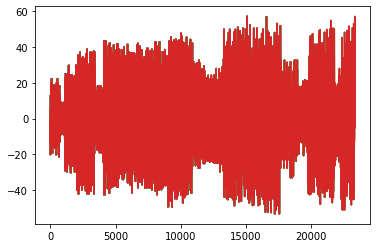

In [26]:
# eval all [-1,1]  15 25 1 .4  
debug = False
diff_ls = evalAll("RegularRunning2",True)

Text(0, 0.5, 'Accuracy')

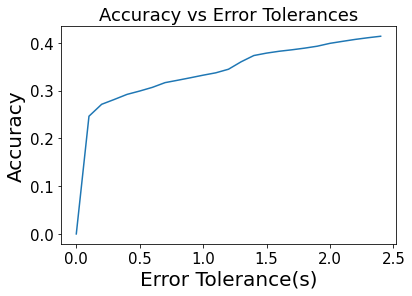

In [33]:
plt.title("Accuracy vs Error Tolerances")
incr, length = .1, 25
x_axis = np.arange(0,length)*incr
y_axis = np.array([np.sum(np.where(np.abs(diff_ls)<incr*i+.000000001,1,0))/len(diff_ls) for i in range(length)])
plt.plot(x_axis,y_axis)
plt.xlabel('Error Tolerance(s)', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)